## Importing Relevant Libraries

In [1]:
import numpy as np
import pandas as pd
from snpc import SNPC
#import katex

## Opening Data sets


In [2]:
X = pd.read_csv("train_data.csv", names = ['A', 'B', 'C'])
y_train = pd.read_csv("train_target.csv", names = ['labels'])
x_test = pd.read_csv("test_data.csv", names = ['A', 'B', 'C'])
print(f'train set shape: {X.shape}')
print(f'target set shape: {y_train.shape}')
print(f'test set shape: {x_test.shape}')

train set shape: (409, 3)
target set shape: (409, 1)
test set shape: (103, 3)


## Encoding label Set

In [3]:
y_train['labels'].unique()
Y = y_train.replace({'labels' :{'leonard': 1, 'sheldon': 2, 'rajesh': 3, 'howard': 4}})
Y.head()

,labels
0,1
1,2
2,4
3,1
4,1


## Split Set into train and test

In [4]:
seed = 42

rng = np.random.default_rng(seed)

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size = 0.2)
X_1 = x_train.to_numpy()
Y_1 = y_train.to_numpy()
Z_1 = x_val.to_numpy()
Y_2 = y_val.to_numpy()
Y_new = Y_2.flatten()


## Prototype Initialisation

In [7]:
def init(data,labels, num_prototypes):
    num_dims = data.shape[1]
    labels = labels.astype(int)
    
    
    unique_labels = np.unique(labels)

    num_protos = num_prototypes * len(unique_labels)
    #prototypes = np.zeros((num_dims, num_protos))
    sigma = 1.0

    proto_labels =  unique_labels
    index = []   
    for i in unique_labels:
        ind=  np.flatnonzero(labels == i)
        index.append(ind) 
    ch_i = []
    for j in range(len(unique_labels)):
        ch_i.append(np.random.choice(index[j], num_prototypes, replace=False))
    N = np.array(ch_i).astype(int).flatten()
    prototypes = data[N]
    new_labels =labels[N]
    return new_labels, prototypes

The aim of SNPC is to reduce the rate of missclassfication. In other words prototype update such that it minimizes the following cost function $$\sum_{i=1}^{N} \sum_{\{j:c_{j} \not = y\}} P(j|x_{i})$$, where 

- $x$ is a data point

- $N$ the number of data points

- $y$ is the class of $x$

- $P(j|x)$ is the probability of getting component $j$ given a set of prototypes $\Tau$

- and $c_{l}$ is the class of some prototype $\theta_l$


Going through its normal exponential form, we deduce that $$ls_{k} = \sum_{\{j:c_{j} \not = y_k \}}P(j|x_{k}) = \frac{P(x_k , \bar{y_k}| \Tau)}{P(x_k |\Tau)}$$ and  $$ P(j|x) = \frac{exp(-d(x , \theta_l))}{\sum_{k=1}^{M} exp(-d(x , \theta_k))}$$
where,

- $M$ is the number of prototypes
- $d(x, \theta_l)$ some distance measure

Prototype update is done by gradien descent as follows:
$$\theta_{l}(t+1) = \theta_{l}(t) - \alpha(t)
\begin{cases}
    \begin{array}{lr}
        P(l|x)(ls_{t})\left[ \frac{\delta f(x, \theta_l)}{\delta \theta_l}\right], & \text{if } c_l = y\\
        -P(l|x)(1 - ls_{t})\left[ \frac{\delta f(x, \theta_l)}{\delta \theta_l}\right], & \text{if } c_l \not= y
    \end{array}
\end{cases} $$

Given a Gaussian Ansatz, we let $d(x, \theta_k) = \frac{(x - \theta_k)^2}{\sigma^2}$

and the gradient descent becomes

$$\theta_{l}(t+1) = \theta_{l}(t) - \alpha(t)
\begin{cases}
    \begin{array}{lr}
        -P(l|x)(ls_{t})(x -\theta_l), & \text{if } c_l = y\\
        P(l|x)(1 - ls_{t})(x -\theta_l), & \text{if } c_l \not= y
    \end{array}
\end{cases} $$


In [8]:
def inner_f(x, p):
    sigma =1

    coef = -1/(2*(sigma *sigma))
    dist = (x -p)@(x- p).T
    return coef*dist

def inner_derivative(x, p):
    sigma = 1
    coef = -1/(sigma *sigma)
    return coef*(x - p)
      
def Pl(x, index, prototypes):
    inner = np.exp(np.array([inner_f(x, p) for p in  prototypes]))# + 1e-10
    numerator = np.exp(np.array(inner_f(x, prototypes[index])))# +1e-10
    denominator = inner.sum()
    return numerator/(denominator) 

def lst(x, prototypes, x_label, proto_labels):
    u = np.exp(np.array([inner_f(x, prototypes[i]) for i in range(len(prototypes)) if x_label != proto_labels[i]]))
    inner = np.exp(np.array([inner_f(x, p) for p in  prototypes])) #+ 1e-10
    den = inner.sum()
    num = u.sum()
    return num/den

def gradient_descent(data,labels, num_prototypes,proto_labels, prototypes):
    
    sigma = 1
    alpha = 0.5
    # = init(data, labels, num_prototypes)
    for i in range(len(data)):
        xi = data[i]
        x_label = labels[i]
        for j in range(prototypes.shape[0]):
            d = (xi - prototypes[j])
            c = 1/(sigma*sigma) 
            if proto_labels[j] == x_label:
                prototypes[j] += alpha*(Pl(xi, j,prototypes)*lst(xi,  prototypes, x_label, proto_labels))*c*d
            else:
                prototypes[j] -= alpha*(Pl(xi,j, prototypes)*(1 - lst(xi,  prototypes, x_label, proto_labels)))*c*d
        
    return prototypes

## Error Function

In [9]:
def Error_function(data,prototypes, labels,num_prototypes):
    
    numerator = []
    denominator = len(data)
    
    
    proto_labels,_  = init(data, labels, num_prototypes) 
    for i in range(len(data)):
        #prototypes = gradient_ascent(data, labels, epochs)
        xi = data[i]
        x_label = labels[i]
        for j in range(len(prototypes)):
            if x_label != proto_labels[j]:
                numerator.append(Pl(xi, j, prototypes))
        
            
            
    a = np.sum(np.array(numerator))
   

    
            
    return a/denominator

In [10]:
o, p = init(X_1, Y_1, 2)
p

array([[-0.71861,  5.93109, -1.24562],
       [-0.40257,  7.8588 , -2.77626],
       [-0.48889,  6.8418 ,  1.07022],
       [-0.67227,  7.2252 , -0.15478],
       [-2.11697, 10.56756,  3.56392],
       [-2.23386,  9.46422,  2.76087],
       [ 0.29547,  9.77017,  3.38336],
       [-0.27485,  9.89002,  3.66081]])

In [11]:
gradient_descent(X_1, Y_1, 2, o, p)


array([[ 0.02533809,  7.94500645, -2.58076443],
       [ 0.01546732,  8.59573592, -2.23300894],
       [-0.15416208,  5.87357694,  1.56563702],
       [-0.58234464,  4.69771578, -0.61843154],
       [-3.14039536, 11.01140413,  3.81617154],
       [-2.92979768,  8.99232935,  1.65395555],
       [ 0.48371335, 10.00266367,  3.7362711 ],
       [ 0.26130664,  9.86817775,  3.81850447]])

## SNPC Implementation

In [12]:
def SNPC(data, labels, num_prototypes, max_iter):
    import matplotlib.pyplot as plt
    proto_labels, prototypes = init(data, labels, num_prototypes)
    loss =[]
    iter = 0

    while iter < max_iter:
        prototypes = gradient_descent(data, labels, num_prototypes,proto_labels, prototypes) 
        error = Error_function(data, prototypes, labels,num_prototypes)
        loss.append(error)
        iter += 1
        print(f'Epoch: {iter}.......... Loss: {error}')

    plt.plot(loss)
    plt.ylabel('Error Function')
    plt.xlabel(' number of iterations')
    return prototypes

Epoch: 1.......... Loss: 0.3571519108362748
Epoch: 2.......... Loss: 0.34319502746713637
Epoch: 3.......... Loss: 0.3389517682230146
Epoch: 4.......... Loss: 0.33367485223438725
Epoch: 5.......... Loss: 0.3257458853760664
Epoch: 6.......... Loss: 0.32225350803558295
Epoch: 7.......... Loss: 0.3231897165165548
Epoch: 8.......... Loss: 0.31619454492337723
Epoch: 9.......... Loss: 0.3181346050875069
Epoch: 10.......... Loss: 0.31748357115010417
Epoch: 11.......... Loss: 0.2525621027304641
Epoch: 12.......... Loss: 0.24238061995706608
Epoch: 13.......... Loss: 0.23322857657933008
Epoch: 14.......... Loss: 0.21068889695357698
Epoch: 15.......... Loss: 0.2069293932874214
Epoch: 16.......... Loss: 0.21389765771554045
Epoch: 17.......... Loss: 0.22792786642055488
Epoch: 18.......... Loss: 0.22287217500096582
Epoch: 19.......... Loss: 0.21929567814206438
Epoch: 20.......... Loss: 0.20889362074160528
Epoch: 21.......... Loss: 0.21159045313956462
Epoch: 22.......... Loss: 0.2118274687712141
Epoch

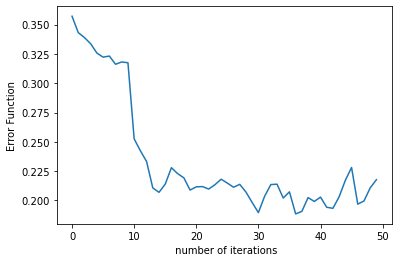

In [13]:
hh = SNPC(X_1, Y_1, 3, 50)

In [14]:
hh

array([[  3.83639216,  10.52899687,  -7.31824739],
       [  4.16011119,  11.9598101 ,  -9.38598943],
       [  3.92619916,  14.06706269,  -5.64034032],
       [  3.29263213,  -3.29144025,   0.70410649],
       [ -0.01623166,  -0.57464564,   0.80739652],
       [  5.96612443,   0.25952637,   3.56189893],
       [ -7.53187921,  12.41109225,   5.76807298],
       [ -5.14924903,  -0.62476337, -10.59107042],
       [ -8.47802741,   4.08282518,  -4.59142305],
       [  1.99498058,   0.38636337,  -9.880873  ],
       [  2.36912178,  -0.78507102,  -8.71544907],
       [  2.15219399,   0.22967153,  -9.18423322]])

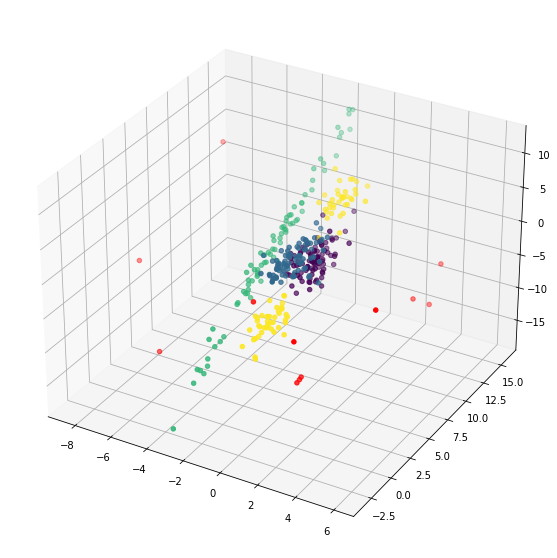

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_1[:,0], X_1[:,1], X_1[:,2], c = Y_1)
ax.scatter(hh[:,0], hh[:,1], hh[:,2], c= 'r')

## Predict Validation Set and measure Accuracy

In [16]:
def predict(data, prototypes, protolabels):
    label = []
    #prototypes, _ = RSLVQ(data, labels, num_prototypes, max_iter)
    for i in range(data.shape[0]):
        xi = data[i]
        distances = np.array([inner_f(xi, p) for p in prototypes])
        index = np.argwhere(distances == distances.max())
        x_label = protolabels[index]
        label.append(x_label)
    return np.array(label).flatten()

In [17]:
def cross_validation(X_n,Y_n, n):
    arr = np.array(range(len(X_n)))
    l = len(X_n)
    t = round(l/n) - 1
    np.random.shuffle(arr)
    cross_val_acc = []
    for i in range(1,n+1):
        test_set = X_n[arr[i-1 + (i)*t: i + (i+1)*t]]
        test_labels = Y_n[arr[i-1 + (i)*t: i + (i+1)*t]]
        t_new = np.array(test_labels).flatten()
        train_indices = np.setdiff1d(arr, arr[i-1 + (i)*t: i + (i+1)*t]) 
        train_set = X_n[train_indices]
        train_labels = Y_n[train_indices]
        pro_lab,_ = init(train_set, train_labels, 3)
        prototype_i = SNPC(train_set, train_labels, 3, 50)
        predict_i = predict(test_set, prototype_i,pro_lab)
        precision_i = np.mean(predict_i == t_new) 
        cross_val_acc.append(precision_i)
    print(f'Accuracies: {cross_val_acc}, Mean: {np.array(cross_val_acc).mean()}, Variance: {np.array(cross_val_acc).var()}')

Epoch: 1.......... Loss: 0.163725945434215
Epoch: 2.......... Loss: 0.14192162928646457
Epoch: 3.......... Loss: 0.13659634224395187
Epoch: 4.......... Loss: 0.13170402266647888
Epoch: 5.......... Loss: 0.1279271684298189
Epoch: 6.......... Loss: 0.12458616251997108
Epoch: 7.......... Loss: 0.12246746839284671
Epoch: 8.......... Loss: 0.1223803736123513
Epoch: 9.......... Loss: 0.12233598340018954
Epoch: 10.......... Loss: 0.12190366537284453
Epoch: 11.......... Loss: 0.12168396762035255
Epoch: 12.......... Loss: 0.122038207320518
Epoch: 13.......... Loss: 0.12257697422753046
Epoch: 14.......... Loss: 0.12227794255151062
Epoch: 15.......... Loss: 0.11807370542242193
Epoch: 16.......... Loss: 0.12494472666013792
Epoch: 17.......... Loss: 0.12995553268867477
Epoch: 18.......... Loss: 0.1238774872573066
Epoch: 19.......... Loss: 0.11931422386803654
Epoch: 20.......... Loss: 0.11822556992081643
Epoch: 21.......... Loss: 0.11886310430270357
Epoch: 22.......... Loss: 0.1170961464706401
Epoch

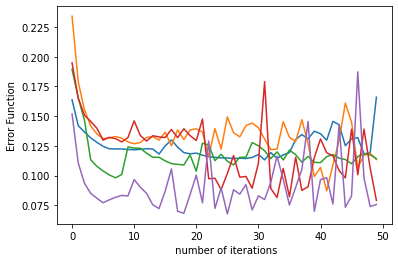

In [18]:
cross_validation(X_1, Y_1, 5)

In [19]:
x,_ = init(X_1, Y_1, 3)
predicted = predict(Z_1,hh, x)
print(f'Accuracy: {np.mean(predicted == Y_new)*100} %')

Accuracy: 71.95121951219512 %


[Text(0.5, 69.0, 'True Values'), Text(69.0, 0.5, 'Predicted Values')]

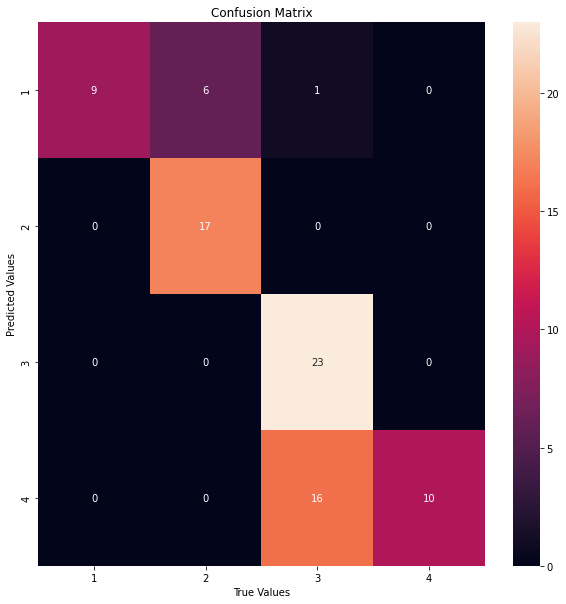

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(Y_new, predicted)
df = pd.DataFrame(cm, columns=[1,2,3,4], index = [1,2,3,4])
plt.figure(figsize = (10,10))
plt.title('Confusion Matrix')
ax = sns.heatmap(df,annot = True)
ax.set(xlabel= 'True Values', ylabel = 'Predicted Values')